21/3/23
at 10:44 

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '50k-celebrity-faces-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3587899%2F6244141%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240320%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240320T162606Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1810bbc27e6367e99308ebbbb158935036cbc1de643eb1b26a8a80a350a7492b2885ad5b2ba5664ef3d68f97219bda54fa04fb91b60bc0f3b4ab17fbf1816e2cbb74722e57bd03d5b5c35727f013cdad67dab3fdcf142ffe6d3873ef7802a218c7dc8a48feda8d9daa435576116fc308e14bf7a78dcda7a8b1c4f5c62a2b3b52f9c82c2d35970bb3357e1fbfcf241cb830486ba6d769be8995f941b3d8c869b524aac9ca9c4a877c9338203d22c679e3be69edeb01290bce251ea5bc23dbf9ea69560c967162e502cf0355c48f47839209098a8bf48c0f4217fa87246b12d2517178e36c97cb85267f6c697181a4bf94e6486def7618494f241c24776b2ca623'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 349562845 bytes downloaded
Downloaded and uncompressed: 50k-celebrity-faces-image-dataset
Data source import complete.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import zeros, ones
from numpy.random import randn, randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU
from keras.layers import BatchNormalization, Dropout, Reshape, Flatten
from tqdm import tqdm
import time
import time
from keras.callbacks import EarlyStopping


In [ ]:
dataset_dir = "/kaggle/input/50k-celebrity-faces-image-dataset/Celebrity_Faces_Dataset"

image_paths = glob.glob(os.path.join(dataset_dir, '*.jpg'))
image_paths = image_paths[:25000]

def load_and_preprocess_real_images(image_path, target_size=(64, 64)):
    img = Image.open(image_path)
    img = img.crop((0, 20, 178, 198))
    img = img.resize(target_size)
    img = np.array(img)/127.5 - 1
    return img

dataset = np.array([load_and_preprocess_real_images(img_path) for img_path in image_paths])

In [ ]:
def build_discriminator(image_shape=(64, 64, 3)):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same', input_shape=image_shape))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(256, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(256, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(512, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
def build_generator(latent_dim, channels=3):
    model = Sequential()
    model.add(Dense(16 * 16 * 128, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((16, 16, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(64, (4, 4), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(channels, (8, 8), activation='tanh', padding='same'))
    return model

In [ ]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
def generate_real_samples(dataset, num_samples):
    sample_indices = randint(0, dataset.shape[0], num_samples)
    X = dataset[sample_indices]
    y = ones((num_samples, 1))
    return X, y

In [ ]:
def generate_noise_samples(num_samples, noise_dim):
    X_noise = randn(noise_dim * num_samples)
    X_noise = X_noise.reshape(num_samples, noise_dim)
    return X_noise

In [ ]:
def generate_fake_samples(generator, noise_dim, num_samples):
    X_noise = generate_noise_samples(num_samples, noise_dim)
    X = generator.predict(X_noise)
    y = zeros((num_samples, 1))
    return X, y

In [ ]:
def generate_images(epoch, generator, num_samples=6, noise_dim=100):
    X_noise = generate_noise_samples(num_samples, noise_dim)
    X = generator.predict(X_noise, verbose=0)
    X = (X + 1) / 2
    return X

In [ ]:
def display_saved_images(saved_images, display_frequency):
    for epoch, images in enumerate(saved_images):
        fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
        for i, img in enumerate(images):
            axes[i].imshow(img)
            axes[i].axis('off')
        fig.suptitle(f"Generated Images at Epoch {epoch*display_frequency + 1}", fontsize=22)
        plt.tight_layout()
        plt.show()

In [ ]:
def plot_generated_images(epoch, generator, num_samples=6, noise_dim=100, figsize=(15, 3)):
    X_noise = generate_noise_samples(num_samples, noise_dim)
    X = generator.predict(X_noise, verbose=0)
    X = (X + 1) / 2
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i in range(num_samples):
        axes[i].imshow(X[i])
        axes[i].axis('off')

    fig.suptitle(f"Generated Images at Epoch {epoch+1}", fontsize=22)
    plt.tight_layout()
    plt.show()

2/2 [==============================] - 0s 28ms/step
[ Epoch: 1/125 , Batch: 1/67 ] --> [ Discriminator Loss : 0.696998 , Discriminator Accuracy: 15.15% ] [ Generator Loss: 0.691730 ]
2/2 [==============================] - 0s 25ms/step
[ Epoch: 1/125 , Batch: 2/67 ] --> [ Discriminator Loss : 0.652982 , Discriminator Accuracy: 50.00% ] [ Generator Loss: 0.689483 ]
2/2 [==============================] - 0s 15ms/step
[ Epoch: 1/125 , Batch: 3/67 ] --> [ Discriminator Loss : 0.580986 , Discriminator Accuracy: 50.00% ] [ Generator Loss: 0.676748 ]
2/2 [==============================] - 0s 14ms/step
[ Epoch: 1/125 , Batch: 4/67 ] --> [ Discriminator Loss : 0.495824 , Discriminator Accuracy: 50.00% ] [ Generator Loss: 0.647953 ]
2/2 [==============================] - 0s 13ms/step
[ Epoch: 1/125 , Batch: 5/67 ] --> [ Discriminator Loss : 0.438699 , Discriminator Accuracy: 50.00% ] [ Generator Loss: 0.657206 ]
2/2 [==============================] - 0s 13ms/step
[ Epoch: 1/125 , Batch: 6/67 ] --

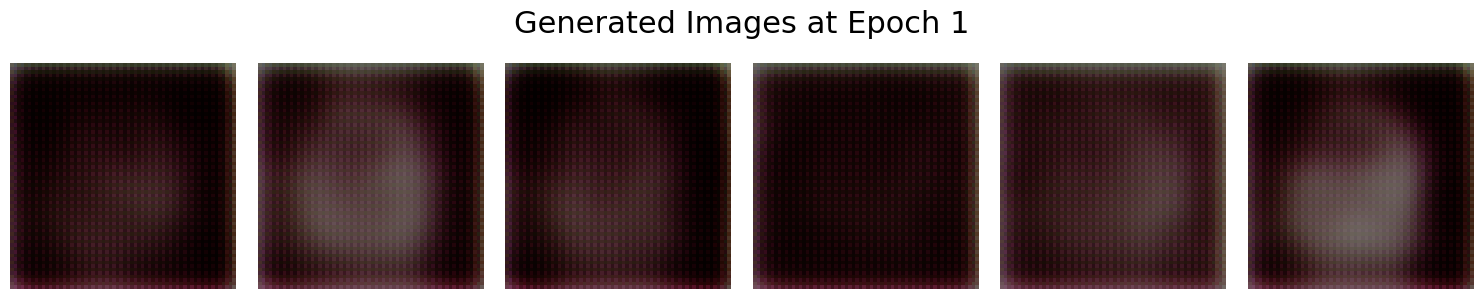

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 13ms/step
[ Epoch: 14/125 , Batch: 47/67 ] --> [ Discriminator Loss : 0.564312 , Discriminator Accuracy: 69.70% ] [ Generator Loss: 1.363854 ]
2/2 [==============================] - 0s 14ms/step
[ Epoch: 14/125 , Batch: 48/67 ] --> [ Discriminator Loss : 0.499523 , Discriminator Accuracy: 83.33% ] [ Generator Loss: 1.351143 ]
2/2 [==============================] - 0s 14ms/step
[ Epoch: 14/125 , Batch: 49/67 ] --> [ Discriminator Loss : 0.585609 , Discriminator Accuracy: 62.12% ] [ Generator Loss: 1.535623 ]
2/2 [==============================] - 0s 14ms/step
[ Epoch: 14/125 , Batch: 50/67 ] --> [ Discriminator Loss : 0.452735 , Discriminator Accuracy: 81.82% ] [ Generator Loss: 1.576527 ]
2/2 [==============================] - 0s 15ms/step
[ Epoch: 14/125 , Batch: 51/67 ] --> [ Discriminator Loss : 0.461361 , Discriminator Accuracy: 81.82% ] [ Generator Loss: 1.766674 ]
2/2 [===================

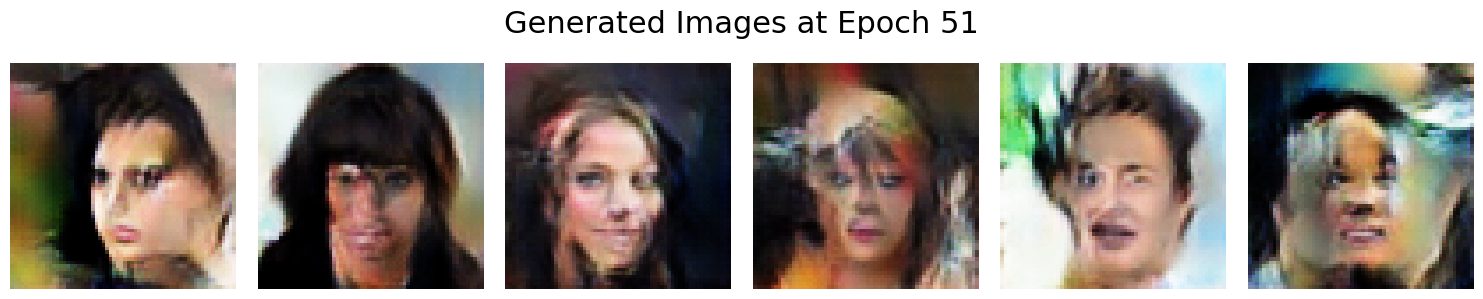

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 14ms/step
[ Epoch: 64/125 , Batch: 47/67 ] --> [ Discriminator Loss : 0.633449 , Discriminator Accuracy: 57.58% ] [ Generator Loss: 0.958340 ]
2/2 [==============================] - 0s 14ms/step
[ Epoch: 64/125 , Batch: 48/67 ] --> [ Discriminator Loss : 0.678605 , Discriminator Accuracy: 56.06% ] [ Generator Loss: 0.978989 ]
2/2 [==============================] - 0s 14ms/step
[ Epoch: 64/125 , Batch: 49/67 ] --> [ Discriminator Loss : 0.641991 , Discriminator Accuracy: 63.64% ] [ Generator Loss: 0.930729 ]
2/2 [==============================] - 0s 14ms/step
[ Epoch: 64/125 , Batch: 50/67 ] --> [ Discriminator Loss : 0.626382 , Discriminator Accuracy: 57.58% ] [ Generator Loss: 0.874070 ]
2/2 [==============================] - 0s 14ms/step
[ Epoch: 64/125 , Batch: 51/67 ] --> [ Discriminator Loss : 0.616837 , Discriminator Accuracy: 65.15% ] [ Generator Loss: 0.931923 ]
2/2 [===================

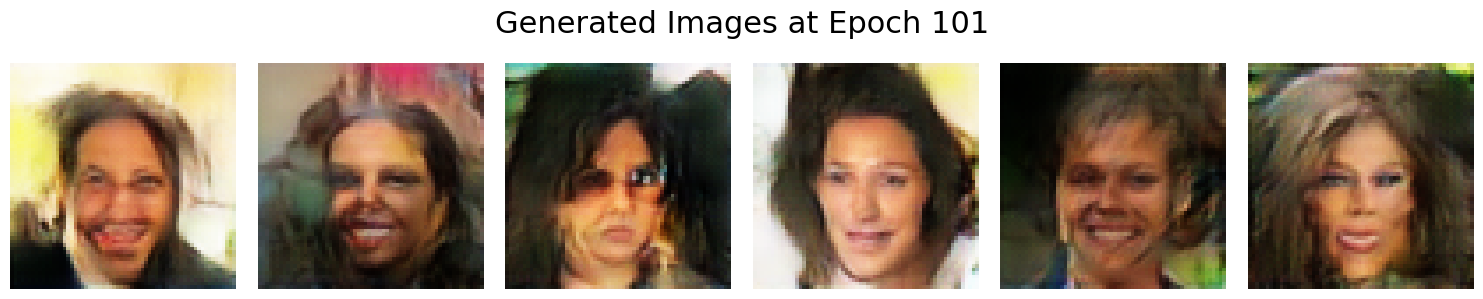

2/2 [==============================] - 0s 13ms/step
[ Epoch: 102/125 , Batch: 1/67 ] --> [ Discriminator Loss : 0.611080 , Discriminator Accuracy: 72.73% ] [ Generator Loss: 0.785939 ]
2/2 [==============================] - 0s 14ms/step
[ Epoch: 102/125 , Batch: 2/67 ] --> [ Discriminator Loss : 0.587448 , Discriminator Accuracy: 72.73% ] [ Generator Loss: 0.750064 ]
2/2 [==============================] - 0s 13ms/step
[ Epoch: 102/125 , Batch: 3/67 ] --> [ Discriminator Loss : 0.736952 , Discriminator Accuracy: 54.55% ] [ Generator Loss: 0.864304 ]
2/2 [==============================] - 0s 14ms/step
[ Epoch: 102/125 , Batch: 4/67 ] --> [ Discriminator Loss : 0.631046 , Discriminator Accuracy: 63.64% ] [ Generator Loss: 0.893053 ]
2/2 [==============================] - 0s 14ms/step
[ Epoch: 102/125 , Batch: 5/67 ] --> [ Discriminator Loss : 0.676286 , Discriminator Accuracy: 62.12% ] [ Generator Loss: 0.898542 ]
2/2 [==============================] - 0s 14ms/step
[ Epoch: 102/125 , Batc

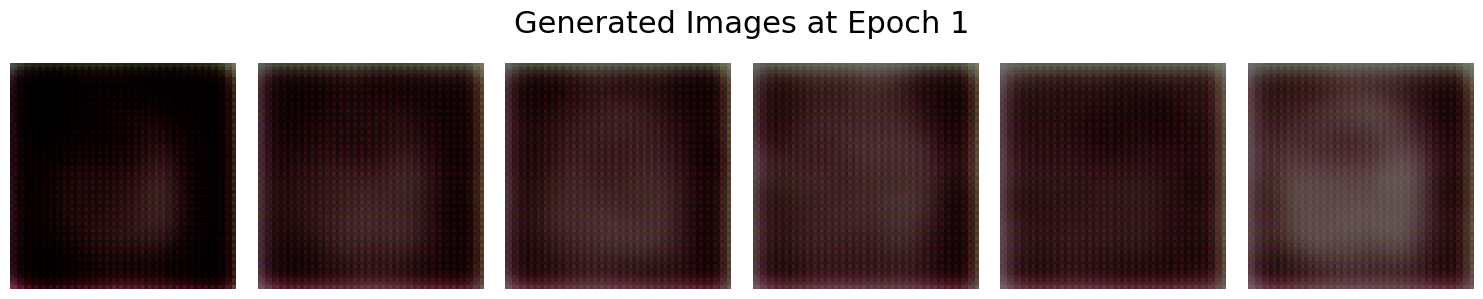

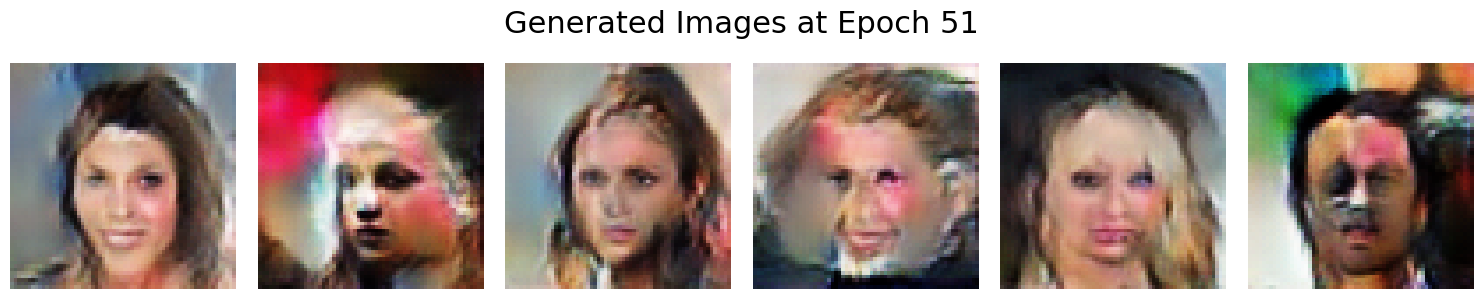

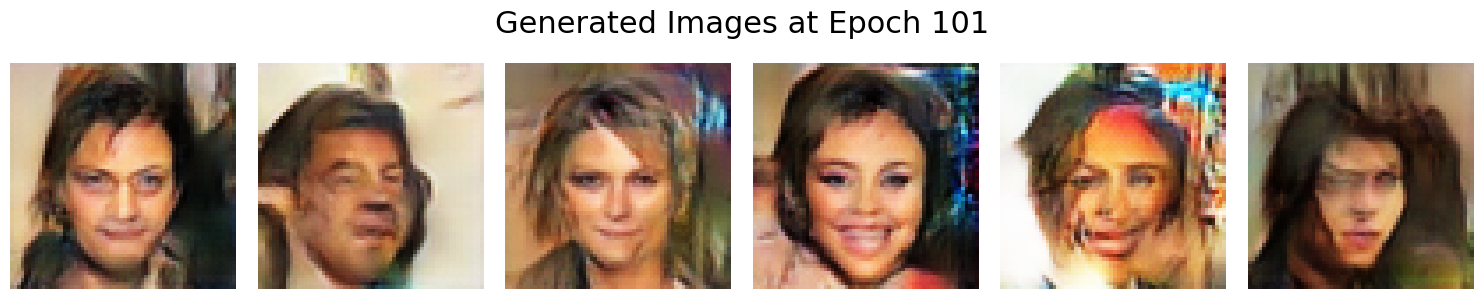

In [ ]:
def train(generator_model, discriminator_model, gan_model, dataset, noise_dimension,
          num_epochs=125, batch_size=67, display_frequency=10, verbose=1):

    # Create an empty list to store generated images for each epoch
    saved_images_for_epochs = []

    # Calculate the number of batches per epoch
    batches_per_epoch = 67

    # Calculate half the size of a batch
    half_batch_size   = int(batch_size / 2)

    # Loop over all epochs
    for epoch in range(num_epochs):
        # Loop over all batches within this epoch
        for batch_num in range(batches_per_epoch):

            # Generate a batch of real images and their corresponding labels
            real_images, real_labels    = generate_real_samples(dataset, half_batch_size)
            # Train the discriminator on the real images and calculate loss and accuracy
            dsr_loss_real, dsr_acc_real = discriminator_model.train_on_batch(real_images, real_labels)

            # Generate a batch of fake images and their corresponding labels
            fake_images, fake_labels    = generate_fake_samples(generator_model, noise_dimension, half_batch_size)
            # Train the discriminator on the fake images and calculate loss and accuracy
            dsr_loss_fake, dsr_acc_fake = discriminator_model.train_on_batch(fake_images, fake_labels)

            # Calculate the average discriminator loss and accuracy over real and fake images
            dsr_loss = 0.5 * np.add(dsr_loss_real, dsr_loss_fake)
            dsr_acc  = 0.5 * np.add(dsr_acc_real, dsr_acc_fake)

            # Generate noise samples and their corresponding labels for training the generator
            gan_noise  = generate_noise_samples(batch_size, noise_dimension)
            gan_labels = np.ones((batch_size, 1))

            # Train the generator and calculate loss
            gen_loss, _ = gan_model.train_on_batch(gan_noise, gan_labels)

            if verbose:
                # Print training information for this batch
                print(f"[ Epoch: {epoch+1}/{num_epochs} , Batch: {batch_num+1}/{batches_per_epoch} ] --> [ Discriminator Loss : {dsr_loss:.6f} , Discriminator Accuracy: {100*dsr_acc:.2f}% ] [ Generator Loss: {gen_loss:.6f} ]")

        if epoch % display_frequency == 0:
            generated_images_for_epoch = generate_images(epoch, generator_model)
            saved_images_for_epochs.append(generated_images_for_epoch)
            plot_generated_images(epoch, generator_model)

    return saved_images_for_epochs

noise_dimension = 100

discriminator = build_discriminator()

generator = build_generator(noise_dimension)

gan_model = build_gan(generator, discriminator)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the GAN model with reduced batch size and early stopping
batch_size = 67
start_time = time.time()
saved_images = train(generator, discriminator, gan_model, dataset, noise_dimension,
                     num_epochs=125, batch_size=batch_size, display_frequency=50, verbose=1)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

# Display the saved generated images
display_saved_images(saved_images, display_frequency=50)


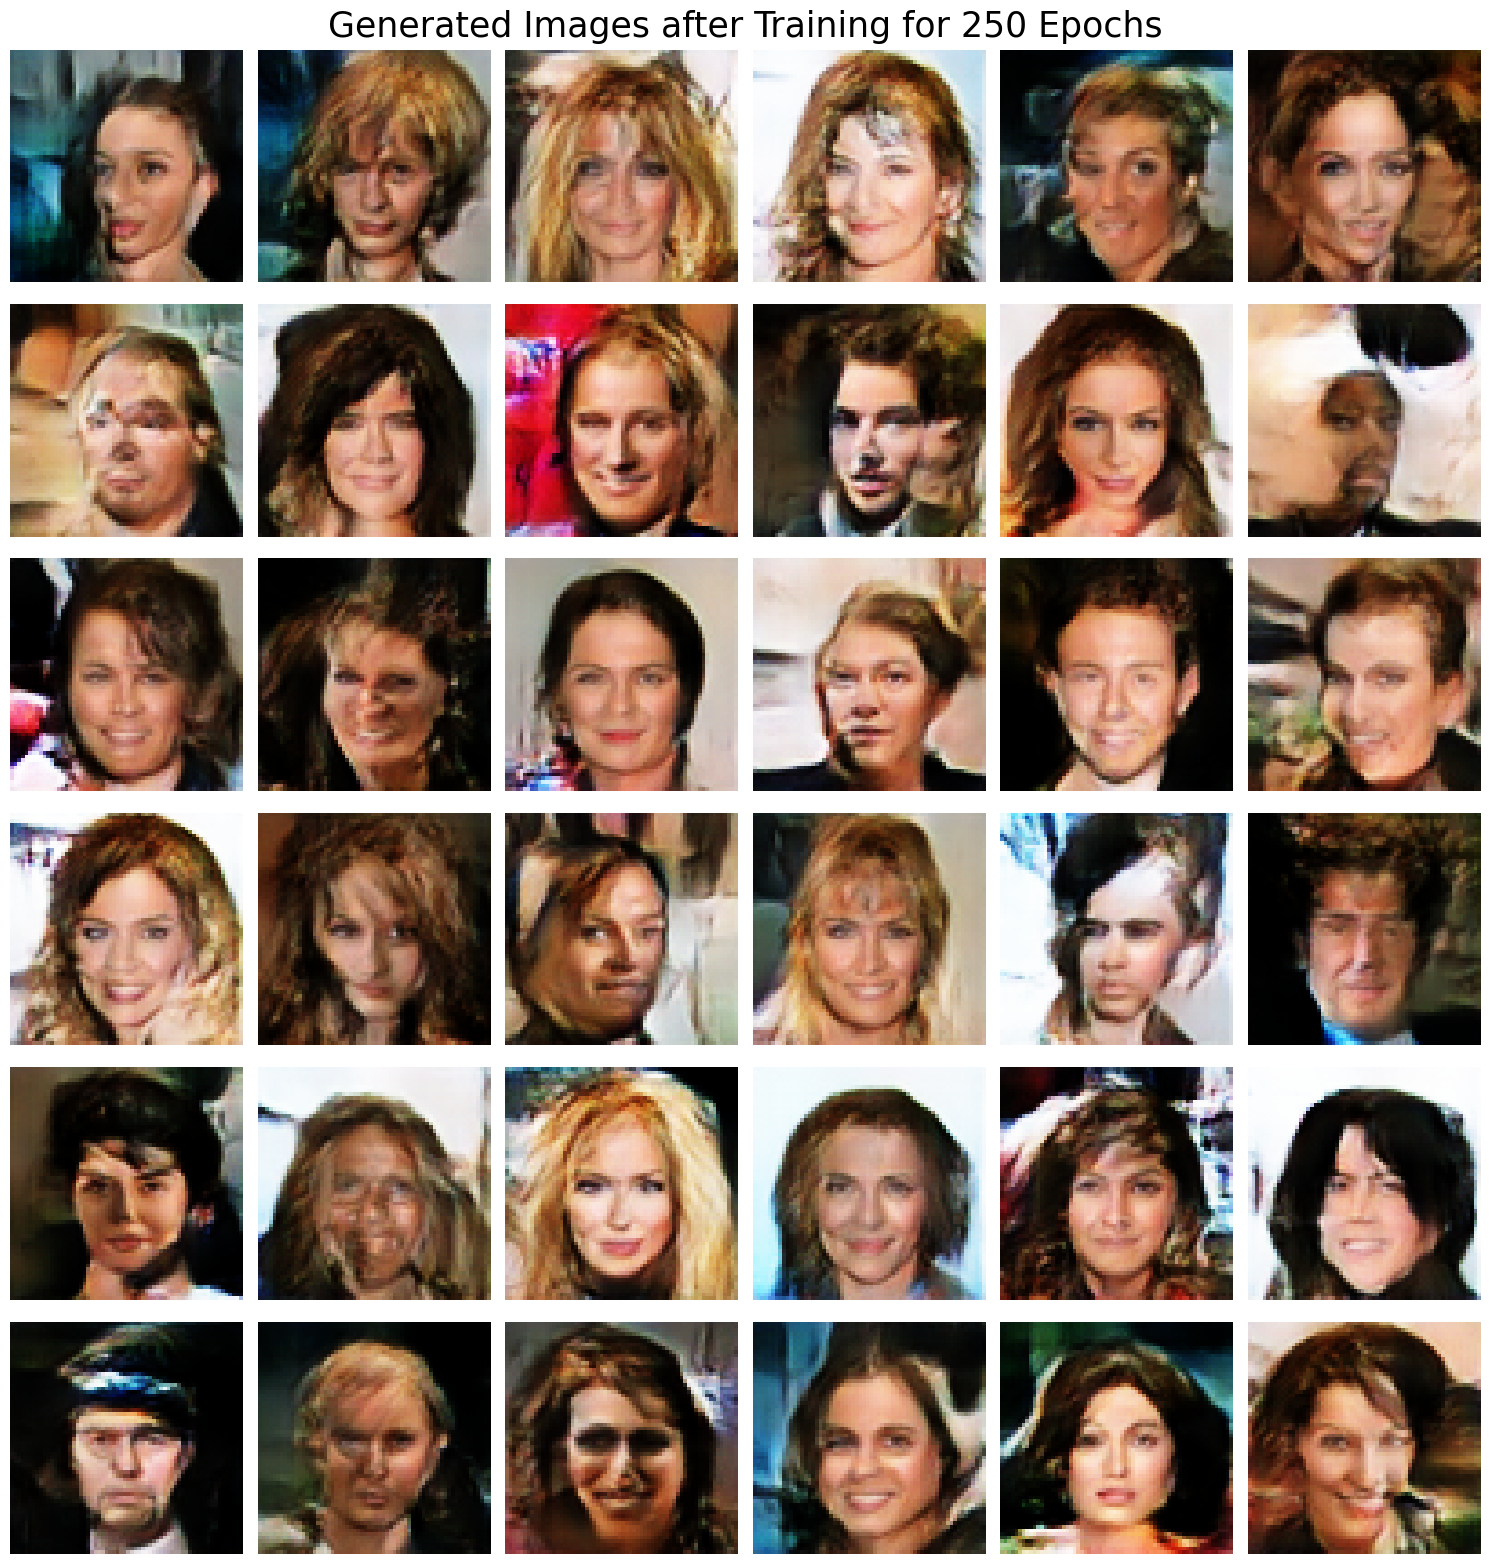

In [ ]:
def plot_generated_images_after_training(generator, noise_dim=100, figsize=(15, 16)):
    fig, axes = plt.subplots(6, 6, figsize=figsize)

    for i, ax in enumerate(axes.flat):
        X_noise = generate_noise_samples(1, noise_dim)
        X = generator.predict(X_noise, verbose=0)
        X = (X + 1) / 2
        ax.imshow(X[0])
        ax.axis('off')

    fig.suptitle('Generated Images after Training for 125 Epochs', fontsize=25)

    plt.tight_layout()
    plt.show()

plot_generated_images_after_training(generator)

In [ ]:
discriminator.save('new_discriminator_model.h5')


In [ ]:
import os
print(os.getcwd())

/content
